# Import Libraries

In [1]:
# Import neccessary libraries
import pandas as pd
import numpy as np

import os
import nibabel as nib
from joblib import dump, load
from tqdm import tqdm
import random
import torch
from collections import Counter
import importlib
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import utils.preprocess_images
import utils.binarise_masks
import utils.extract_slices
import utils.dataset
import utils.augmentation

importlib.reload(utils.preprocess_images)
importlib.reload(utils.binarise_masks)
importlib.reload(utils.extract_slices)
importlib.reload(utils.dataset)
importlib.reload(utils.augmentation)

from utils.preprocess_images import preprocess_all
from utils.binarise_masks import binarise_all
from utils.extract_slices import extract_slices
from utils.dataset import CardiacMRIDataset
from utils.augmentation import get_train_transform, get_eval_transform

# Set Seed

In [2]:
# Define a function to set seeds for reproducibility
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [3]:
set_seed()

# Directory Setup

In [4]:
# Define base paths
path_data = './MnM2/dataset/'                        # Raw data (original .nii.gz files)
path_out_3d = './MnM2_preprocessed_3D/'              # Output: preprocessed 3D volumes
path_out_2dslices = './MnM2_preprocessed_2Dslices/'  # Output: 2D slices from 3D volumes

In [5]:
# Define 3D output folders
path_images_3d = os.path.join(path_out_3d, 'images') # Preprocessed 3D images
path_masks_3d = os.path.join(path_out_3d, 'masks')   # Binarised 3D RV masks

In [6]:
# Define 2D output folders (sliced from 3D)
path_train_images_2d = os.path.join(path_out_2dslices, 'train', 'images')
path_train_masks_2d  = os.path.join(path_out_2dslices, 'train', 'masks')

path_val_images_2d   = os.path.join(path_out_2dslices, 'val', 'images')
path_val_masks_2d    = os.path.join(path_out_2dslices, 'val', 'masks')

path_test_images_2d  = os.path.join(path_out_2dslices, 'test', 'images')
path_test_masks_2d   = os.path.join(path_out_2dslices, 'test', 'masks')

In [7]:
# Create all directories
os.makedirs(path_images_3d, exist_ok=True)
os.makedirs(path_masks_3d, exist_ok=True)

os.makedirs(path_train_images_2d, exist_ok=True)
os.makedirs(path_train_masks_2d, exist_ok=True)

os.makedirs(path_val_images_2d, exist_ok=True)
os.makedirs(path_val_masks_2d, exist_ok=True)

os.makedirs(path_test_images_2d, exist_ok=True)
os.makedirs(path_test_masks_2d, exist_ok=True)

# Load Dataset

In [8]:
# Load dataset
df_csv = pd.read_csv('./MnM2/dataset_information.csv', dtype=str)

print("Total number of rows:", len(df_csv))

Total number of rows: 1048574


In [9]:
# Only the first 360 rows have values
df_csv = df_csv.iloc[:360,:]

# Display the dataset
display(df_csv)

,SUBJECT_CODE,DISEASE,VENDOR,SCANNER,FIELD
0,1,NOR,GE MEDICAL SYSTEMS,SIGNA EXCITE,1.5
1,2,NOR,GE MEDICAL SYSTEMS,SIGNA EXCITE,1.5
2,3,NOR,GE MEDICAL SYSTEMS,SIGNA EXCITE,1.5
3,4,NOR,GE MEDICAL SYSTEMS,SIGNA EXCITE,1.5
4,5,NOR,GE MEDICAL SYSTEMS,SIGNA EXCITE,1.5
...,...,...,...,...,...
355,356,TRI,SIEMENS,Symphony,1.5
356,357,TRI,SIEMENS,SymphonyTim,1.5
357,358,TRI,SIEMENS,Symphony,1.5
358,359,TRI,SIEMENS,SymphonyTim,1.5


In [10]:
# Standardise the subject code to three digits, eg. 001, 002,...,360
df_csv['SUBJECT_CODE'] = df_csv['SUBJECT_CODE'].apply(lambda x: str(x).zfill(3))

In [11]:
# Insert set type: training, validation and testing
df_csv.insert(1, "SET_TYPE", ["Train"]*160 + ["Validation"]*40 + ["Test"]*160)

In [12]:
display(df_csv)

,SUBJECT_CODE,SET_TYPE,DISEASE,VENDOR,SCANNER,FIELD
0,001,Train,NOR,GE MEDICAL SYSTEMS,SIGNA EXCITE,1.5
1,002,Train,NOR,GE MEDICAL SYSTEMS,SIGNA EXCITE,1.5
2,003,Train,NOR,GE MEDICAL SYSTEMS,SIGNA EXCITE,1.5
3,004,Train,NOR,GE MEDICAL SYSTEMS,SIGNA EXCITE,1.5
4,005,Train,NOR,GE MEDICAL SYSTEMS,SIGNA EXCITE,1.5
...,...,...,...,...,...,...
355,356,Test,TRI,SIEMENS,Symphony,1.5
356,357,Test,TRI,SIEMENS,SymphonyTim,1.5
357,358,Test,TRI,SIEMENS,Symphony,1.5
358,359,Test,TRI,SIEMENS,SymphonyTim,1.5


# Exploratory Data Analysis

## Disease Distribution

In [13]:
# Count the number of subjects per disease
disease_counts = df_csv['DISEASE'].value_counts().sort_values(ascending=False)

print("Disease distribution:\n", disease_counts)

Disease distribution:
 DISEASE
NOR     75
LV      60
HCM     60
ARR     35
FALL    35
CIA     35
RV      30
TRI     30
Name: count, dtype: int64


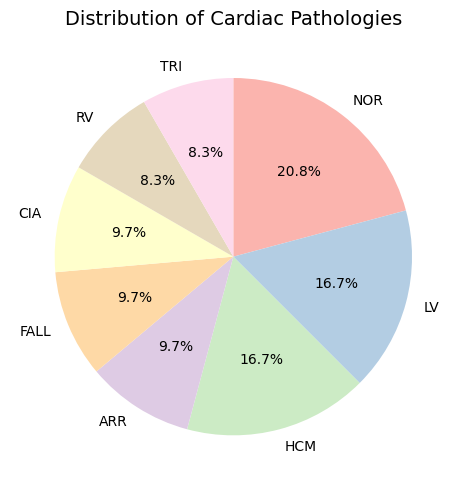

In [14]:
# Plot pie chart of disease distribution
plt.figure(figsize=(5, 5))
colors = plt.cm.Pastel1.colors
disease_counts.plot(
    kind='pie', 
    autopct='%1.1f%%', 
    startangle=90,
    counterclock=False,
    colors=colors
)
plt.title('Distribution of Cardiac Pathologies', fontsize=14)
plt.ylabel('')
plt.tight_layout()
plt.show()

## Choose Pathologies

In [15]:
# Select three pathology types: NOR, LV and HCM (3 highest frequency)
selected_df_csv = df_csv[df_csv["DISEASE"].isin(["NOR", "LV", "HCM"])]

In [16]:
selected_df_csv

,SUBJECT_CODE,SET_TYPE,DISEASE,VENDOR,SCANNER,FIELD
0,001,Train,NOR,GE MEDICAL SYSTEMS,SIGNA EXCITE,1.5
1,002,Train,NOR,GE MEDICAL SYSTEMS,SIGNA EXCITE,1.5
2,003,Train,NOR,GE MEDICAL SYSTEMS,SIGNA EXCITE,1.5
3,004,Train,NOR,GE MEDICAL SYSTEMS,SIGNA EXCITE,1.5
4,005,Train,NOR,GE MEDICAL SYSTEMS,SIGNA EXCITE,1.5
...,...,...,...,...,...,...
275,276,Test,HCM,SIEMENS,SymphonyTim,1.5
276,277,Test,HCM,SIEMENS,SymphonyTim,1.5
277,278,Test,HCM,SIEMENS,SymphonyTim,1.5
278,279,Test,HCM,SIEMENS,SymphonyTim,1.5


## Data Distribution

In [17]:
# Group data by set type and disease
sunburst_data = selected_df_csv.groupby(['SET_TYPE', 'DISEASE']).size().reset_index(name='Count')

# Define colour mapping
unique_sets = sunburst_data['SET_TYPE'].unique()
default_colors = px.colors.qualitative.Pastel
color_discrete_map = {set_type: default_colors[i % len(default_colors)] for i, set_type in enumerate(unique_sets)}

# Plot sunburst piechart
fig = px.sunburst(
    sunburst_data,
    path=['SET_TYPE', 'DISEASE'],
    values='Count',
    color='SET_TYPE',
    color_discrete_map=color_discrete_map,
)

# Update trace text
fig.update_traces(textinfo='label+percent entry')
fig.update_traces(insidetextorientation='horizontal')

# Update layout
fig.update_layout(
    width=500, # adjust width in pixels
    height=500, # adjust height in pixels
    title_text="Dataset Distribution by Set Type and Disease",
    title_x=0.5
)

fig.show()

## Quality Checking

### Verify Segmentation Masks
Ensure that ground truth masks are present and contain valid label values.

### Check Folder Structure & File Availability
Confirm that each subject folder exists, includes 
- A usable image (SA_ED or SA_ES)
- A corresponding ground truth (_gt) file
- Check for corrupted or unreadable .nii.gz files

In [18]:
# Get a sorted list of subject folders, eg. 001, 002,..., 360)
subject_folders = sorted(os.listdir(path_data))

In [19]:
# Initialise trackers
missing_folders = [] # Subjects whose folders are missing entirely
missing_images = []  # Subjects missing usable SA_ED or SA_ES image
missing_masks = []   # Subjects missing corresponding ground truth masks
corrupt_files = []   # Subjects with corrupted or unreadable .nii.gz files
label_summary = {}   # Store unique labels found in each subject's mask

# Loop through all subject folders
for subject_id in tqdm(subject_folders):
    subject_path = os.path.join(path_data, subject_id)

    # Check if folder exists
    if not os.path.isdir(subject_path):
        missing_folders.append(subject_id)
        continue

    # List all files in folder
    files = os.listdir(subject_path)

    # Look for a usable image file (Prefer SA_ED, otherwise SA_ES)
    # Exclude ground truth mask files from image selection
    img_file = next((f for f in files if 'SA_ED.nii.gz' in f and 'gt' not in f), None)
    if not img_file:
        img_file = next((f for f in files if 'SA_ES.nii.gz' in f and 'gt' not in f), None)

    if not img_file:
        missing_images.append(subject_id)
        continue

    # Construct expected mask filename, eg. SA_ED.nii.gz -> SA_ED_gt.nii.gz
    gt_file = img_file.replace('.nii.gz', '_gt.nii.gz')
    if gt_file not in files:
        missing_masks.append(subject_id)
        continue

    # Attempt to load image and mask
    # Record corrupted files if loading fails
    try:
        img_path = os.path.join(subject_path, img_file)
        mask_path = os.path.join(subject_path, gt_file)

        _ = nib.load(img_path).get_fdata()     # Load image
        mask = nib.load(mask_path).get_fdata() # Load mask

        # Extract and store unique labels in mask
        unique_labels = np.unique(mask)
        label_summary[subject_id] = unique_labels

    except Exception as e:
        # Record corrupted subject and error message
        corrupt_files.append((subject_id, str(e)))
        continue

# Summarise label combinations
label_combos = [', '.join(map(str, labels)) for labels in label_summary.values()]
combo_counts = Counter(label_combos)

100%|██████████| 360/360 [00:14<00:00, 24.44it/s]


In [20]:
# Print summary
print(f"Missing subject folders: {missing_folders}")
print(f"Subjects missing usable image (SA_ED or SA_ES): {missing_images}")
print(f"Subjects missing ground truth masks: {missing_masks}")

print("\nSubjects with corrupt .nii.gz files:")
for sid, error in corrupt_files:
    print(f" - {sid}: {error}")

print("\nUnique label combinations across subjects:")
for combo, count in combo_counts.items():
    print(f"Labels: [{combo}]: {count} subject(s)")

Missing subject folders: []
Subjects missing usable image (SA_ED or SA_ES): []
Subjects missing ground truth masks: []

Subjects with corrupt .nii.gz files:

Unique label combinations across subjects:
Labels: [0.0, 1.0, 2.0, 3.0]: 360 subject(s)


<br>**The segmentation label mapping is defined as follows:**</br>
0 – Background: Pixels that do not belong to any cardiac structure (non-heart tissue and surrounding areas).

1 – Left Ventricle (LV): Refers to the cavity of the left ventricle, which pumps oxygenated blood to the body.

2 – Myocardium (Myo): Refers to the muscular wall of the heart, specifically between the left and right ventricles.

3 – Right Ventricle (RV): Refers to the cavity of the right ventricle, which pumps deoxygenated blood to the lungs.

## Image Dimension Consistency Check

In [21]:
# Initialise tracker
image_shapes = [] # Store image shapes (height, width, number of slices)

# Loop through subject folders
for subject_id in tqdm(subject_folders):
    subject_path = os.path.join(path_data, subject_id)
    
    # Check if folder exists
    if not os.path.isdir(subject_path):
        continue

    # List all files in folder
    files = os.listdir(subject_path)

    # Try to find SA_ED or SA_ES image (non-gt), SA_ED (preferred)
    img_file = next((f for f in files if 'SA_ED.nii.gz' in f and 'gt' not in f), None)
    
    # If not found, try SA_ES
    if not img_file:
        img_file = next((f for f in files if 'SA_ES.nii.gz' in f and 'gt' not in f), None)
    
    # If no usable image file is found, skip this subject
    if not img_file:
        continue

    # Try loading the image and record its shape
    try:
        img_data = nib.load(os.path.join(subject_path, img_file)).get_fdata()
        image_shapes.append(img_data.shape) # (height, width, slices)
    except:
        continue

# Convert to DataFrame
df_image_shapes = pd.DataFrame(image_shapes, columns=['Height', 'Width', 'Slices'])


100%|██████████| 360/360 [00:06<00:00, 58.23it/s]


In [22]:
# Print summary statistics
print("Summary statistics of image dimensions:")
print(df_image_shapes.describe())

Summary statistics of image dimensions:
           Height       Width      Slices
count  360.000000  360.000000  360.000000
mean   281.455556  262.572222   11.288889
std     68.372511   80.081541    1.858471
min    192.000000  196.000000    6.000000
25%    240.000000  196.000000   10.000000
50%    256.000000  240.000000   11.000000
75%    320.000000  320.000000   12.000000
max    512.000000  512.000000   28.000000


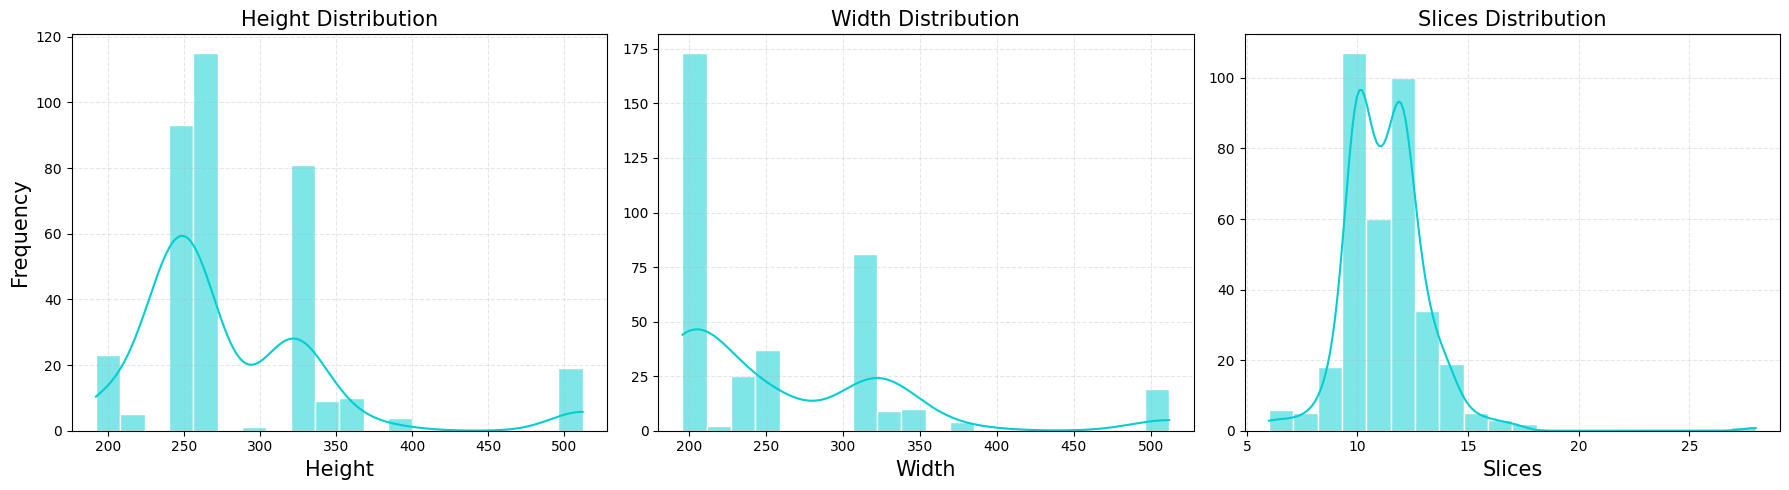

In [23]:
# Plot distribution of each dimension
plt.figure(figsize=(18, 5))

for i, col in enumerate(['Height', 'Width', 'Slices']):
    plt.subplot(1, 3, i+1)
    sns.histplot(df_image_shapes[col], kde=True, bins=20, color="darkturquoise", edgecolor="white")
    plt.title(f'{col} Distribution', fontsize=15)
    plt.xlabel(col, fontsize=15)
    plt.grid(True, linestyle='--', alpha=0.3)
    if i == 0:
        plt.ylabel('Frequency', fontsize=15)
    else:
        plt.ylabel('')

plt.tight_layout()
plt.show()

## Sample Image and Ground Truth Visualisation

In [24]:
# Define files
subject_id = "001"
cardiac_imaging = "ED" # Choose either "ED" or "ES"

# Map phase abbreviation to full name
phase_map = {"ED": "End-Diastole", "ES": "End-Systole"}
phase_name = phase_map.get(cardiac_imaging, "Unknown Phase")

image_file = f"{subject_id}_SA_{cardiac_imaging}.nii.gz"
mask_file = f"{subject_id}_SA_{cardiac_imaging}_gt.nii.gz"

In [25]:
# Load image and mask
img_path = os.path.join(path_data, subject_id, image_file)
mask_path = os.path.join(path_data, subject_id, mask_file)

img = nib.load(img_path).get_fdata()
mask = nib.load(mask_path).get_fdata()

print(f"Shape of cardiac MRI scan for {subject_id} ({phase_name}):", img.shape) # (height, width, #slices)

Shape of cardiac MRI scan for 001 (End-Diastole): (256, 256, 12)


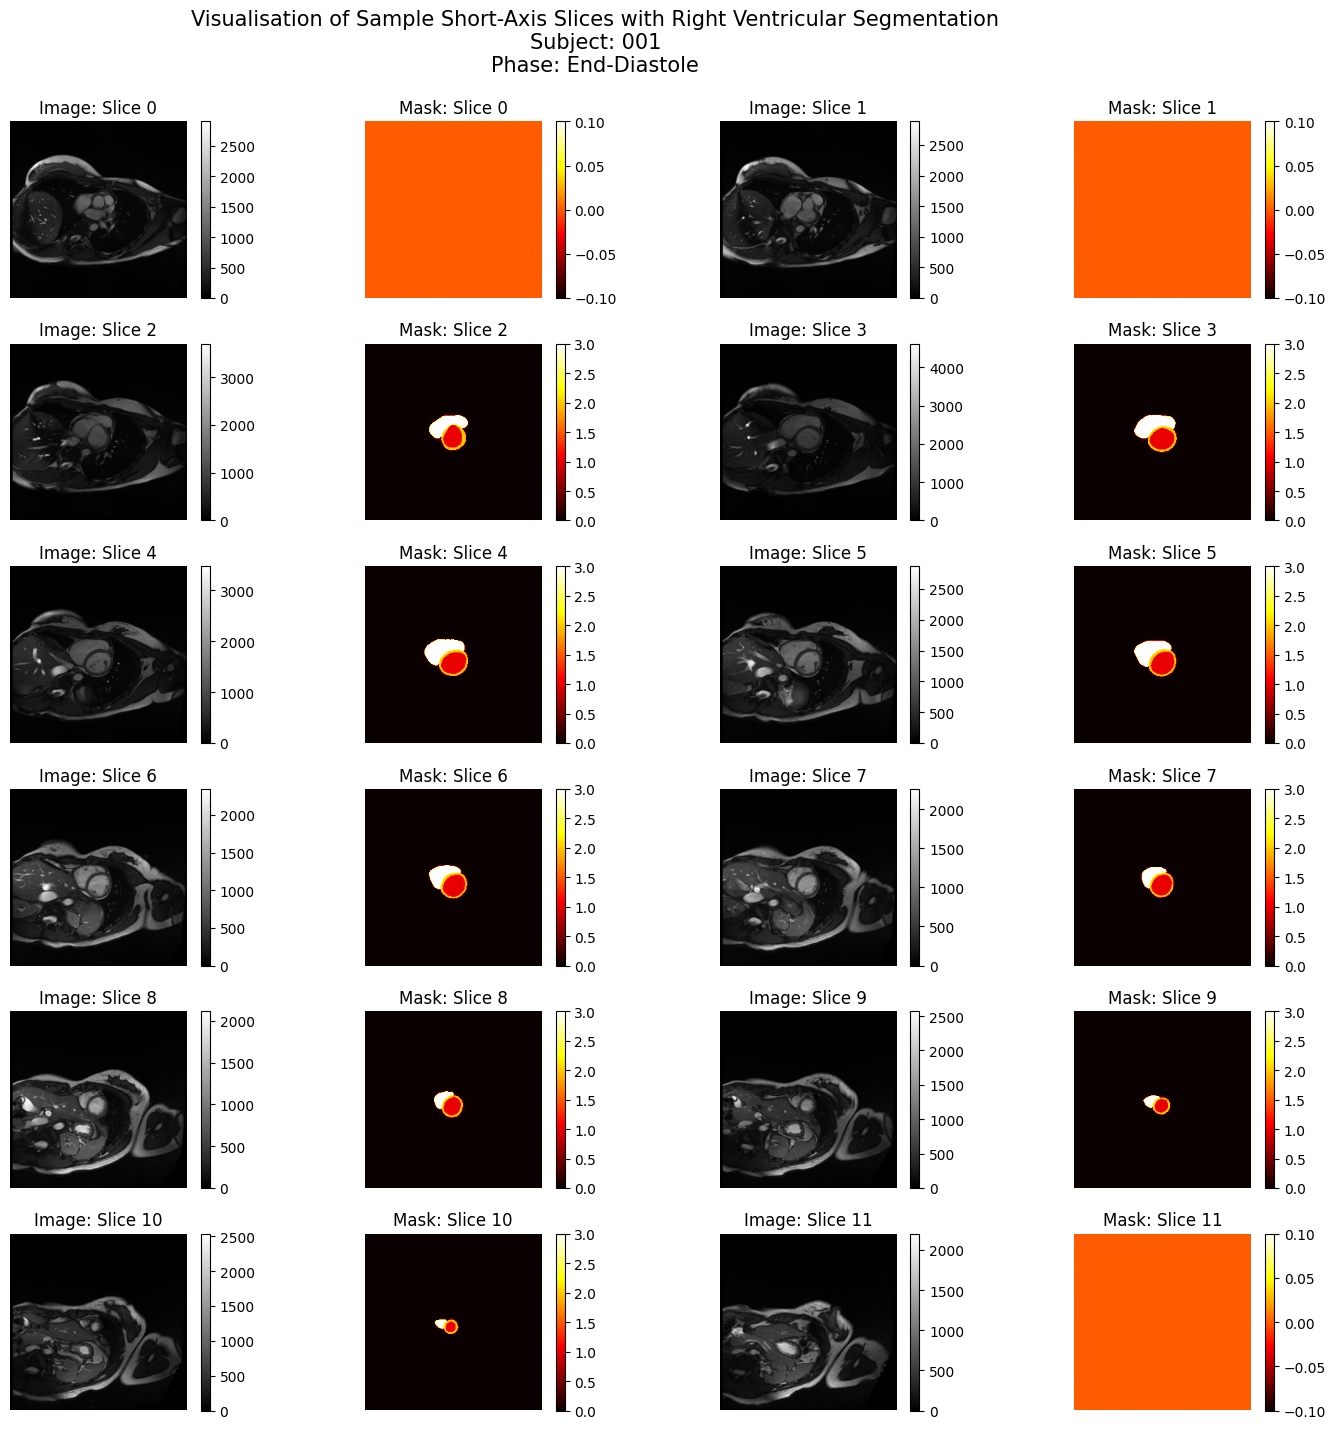

In [26]:
# Visualise image and mask side by side
fig, axs = plt.subplots(6, 4, figsize=(15, 15))

for j in range(img.shape[2]):
    i = j * 2

    # Display MRI slice
    ax_img = axs.flatten()[i]
    im1 = ax_img.imshow(img[:, :, j], cmap='gray')
    ax_img.set_title(f"Image: Slice {j}", fontsize=12)
    ax_img.axis('off')
    plt.colorbar(im1, ax=ax_img, fraction=0.046, pad=0.04)

    # Display corresponding mask
    ax_mask = axs.flatten()[i + 1]
    im2 = ax_mask.imshow(mask[:, :, j], cmap='hot')
    ax_mask.set_title(f"Mask: Slice {j}", fontsize=12)
    ax_mask.axis('off')
    plt.colorbar(im2, ax=ax_mask, fraction=0.046, pad=0.04)

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.suptitle(f"Visualisation of Sample Short-Axis Slices with Right Ventricular Segmentation\nSubject: {subject_id}\nPhase: {phase_name}", x=0.5, ha='center', fontsize=15)
plt.show()

## Overlay MRI Slice with Segmentation Mask Visualisation

In [27]:
# Define files
normal_subID = "001"
lv_subID = "050"
hcm_subID = "080"

In [28]:
# Define paths and load sample subjects
normal_subID = "001"
lv_subID = "050"
hcm_subID = "080"

sample_vis = {
    "Normal": {
        "img": nib.load(os.path.join(path_data, normal_subID, f"{normal_subID}_SA_{cardiac_imaging}.nii.gz")).get_fdata(),
        "gt": nib.load(os.path.join(path_data, normal_subID, f"{normal_subID}_SA_{cardiac_imaging}_gt.nii.gz")).get_fdata()
    },
    "Dilated Left Ventricle": {
        "img": nib.load(os.path.join(path_data, lv_subID, f"{lv_subID}_SA_{cardiac_imaging}.nii.gz")).get_fdata(),
        "gt": nib.load(os.path.join(path_data, lv_subID, f"{lv_subID}_SA_{cardiac_imaging}_gt.nii.gz")).get_fdata()
    },
    "Hypertrophic Cardiomyopathy": {
        "img": nib.load(os.path.join(path_data, hcm_subID, f"{hcm_subID}_SA_{cardiac_imaging}.nii.gz")).get_fdata(),
        "gt": nib.load(os.path.join(path_data, hcm_subID, f"{hcm_subID}_SA_{cardiac_imaging}_gt.nii.gz")).get_fdata()
    }
}

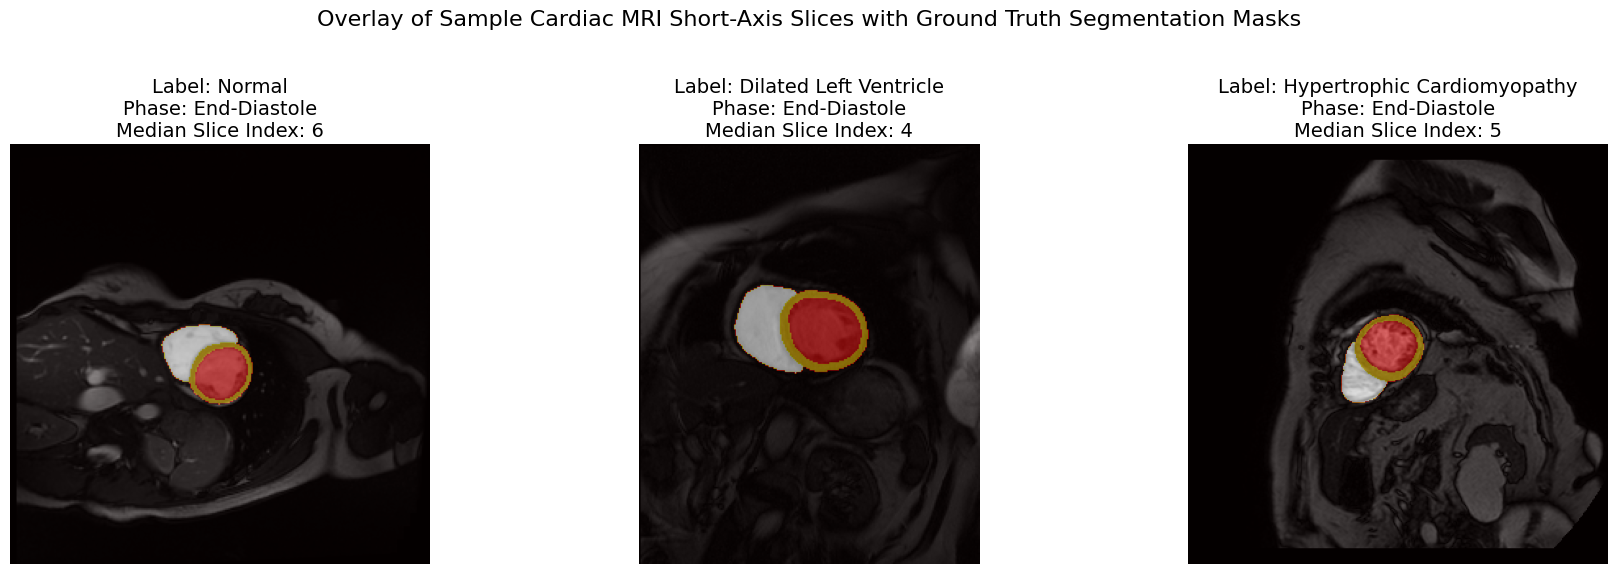

In [29]:
# Plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, (label, data) in enumerate(sample_vis.items()):
    img = data['img']
    gt = data['gt']
    median_slice = img.shape[2] // 2

    ax = axs[i]
    ax.imshow(img[:, :, median_slice], cmap='gray')
    ax.imshow(gt[:, :, median_slice], cmap='hot', alpha=0.5) # Overlay mask
    ax.set_title(f"Label: {label}\nPhase: {phase_name}\nMedian Slice Index: {median_slice}", fontsize=14)
    ax.axis('off')

plt.suptitle(f"Overlay of Sample Cardiac MRI Short-Axis Slices with Ground Truth Segmentation Masks", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Data Preprocessing

In [30]:
# Filter all relevant SA files, only includes ED/ES and excludes CINE
sa_files = []

for (dirpath, _, filenames) in os.walk(path_data):
    for file in filenames:
        parts = file.split('_')

        if len(parts) >= 3 and parts[1] == 'SA' and parts[2].split('.')[0] in ['ED','ES'] and 'CINE' not in parts[2]:
            sa_files.append((dirpath, file))

print("Total SA files:", len(sa_files))

Total SA files: 1440


In [31]:
# Split filtered files into image files and mask files
sa_image_files = [] # Images: regular MRI scans
sa_mask_files = []  # Masks: files containing gt

for (dirpath, file) in sa_files:
    if "gt" in file.lower():
        sa_mask_files.append((dirpath, file))
    else:
        sa_image_files.append((dirpath, file))

print("Total SA image files:", len(sa_image_files))
print("Total SA mask files:", len(sa_mask_files))

Total SA image files: 720
Total SA mask files: 720


## Preprocessing Images

In [32]:
preprocess_all(path_data, path_images_3d, file_list=sa_image_files)

Total image files to preprocess: 720


Processing images: 100%|██████████| 720/720 [02:49<00:00,  4.26it/s]

Preprocessing of 3D images complete...
All preprocessed 3D images have been saved to: ./MnM2_preprocessed_3D/images


### Visualise Preprocessed Sample Images

In [33]:
# Choose samples
example_ids = ['001', '025', '156']
example_img_pairs = []

In [34]:
# Find both ED and ES paths for each subject
for subject_id in example_ids:
    subject_dir = os.path.join(path_images_3d, subject_id)

    ed_img_path = os.path.join(subject_dir, f"{subject_id}_SA_ED.nii.gz")
    es_img_path = os.path.join(subject_dir, f"{subject_id}_SA_ES.nii.gz")

    # Verify both files exist
    if os.path.exists(ed_img_path) and os.path.exists(es_img_path):
        example_img_pairs.append((ed_img_path, es_img_path))
    else:
        print(f"Missing ED or ES image for subject {subject_id}")

print(f"Collected {len(example_img_pairs)} subject image pairs for visualisation")

Collected 3 subject image pairs for visualisation


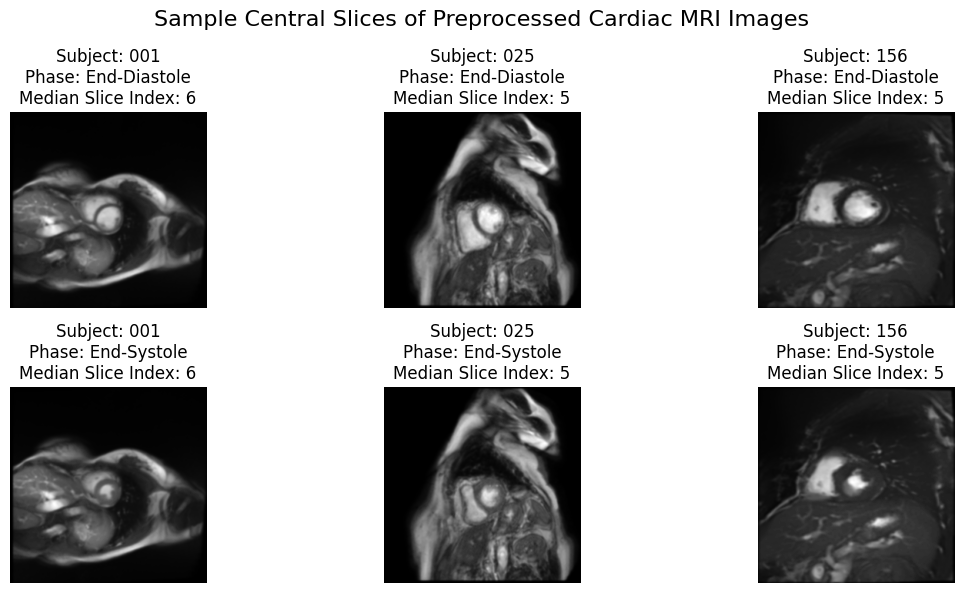

In [35]:
plt.figure(figsize=(12, 6))

for col, (ed_img_path, es_img_path) in enumerate(example_img_pairs):
    for row, (path, phase) in enumerate(zip([ed_img_path, es_img_path], ['End-Diastole', 'End-Systole'])):
        
        # Load preprocessed image
        processed_img_nifti = nib.load(path)
        processed_img_data = processed_img_nifti.get_fdata()

        # Show central slice
        central_slice_idx = processed_img_data.shape[2] // 2
        central_slice = processed_img_data[:, :, central_slice_idx]

        # Plot in correct position
        plt.subplot(2, 3, row * 3 + col + 1)
        plt.imshow(central_slice, cmap='gray')
        subject_id = os.path.basename(path).split('_')[0]
        plt.title(f"Subject: {subject_id}\nPhase: {phase}\nMedian Slice Index: {central_slice_idx}", fontsize=12)
        plt.axis('off')

plt.suptitle("Sample Central Slices of Preprocessed Cardiac MRI Images", fontsize=16)
plt.tight_layout()
plt.show()

## Binarise Right Ventricular (RV) Segmentation Masks

In [36]:
binarise_all(path_data, path_masks_3d, file_list=sa_mask_files)

Total mask files to binarise: 720


Processing masks: 100%|██████████| 720/720 [00:23<00:00, 30.14it/s]

Preprocessing of masks complete...
All preprocessed masks have been saved to: ./MnM2_preprocessed_3D/masks


### Visualise Binarised Sample RV Masks

In [37]:
# Choose samples
example_ids = ['001', '025', '156']
example_mask_pairs = []

In [38]:
# Find both ED and ES paths for each subject
for subject_id in example_ids:
    subject_dir = os.path.join(path_masks_3d, subject_id)

    ed_mask_path = os.path.join(subject_dir, f"{subject_id}_SA_ED_gt.nii.gz")
    es_mask_path = os.path.join(subject_dir, f"{subject_id}_SA_ES_gt.nii.gz")

    # Verify both files exist
    if os.path.exists(ed_mask_path) and os.path.exists(es_mask_path):
        example_mask_pairs.append((ed_mask_path, es_mask_path))
    else:
        print(f"Missing ED or ES mask for subject {subject_id}")

print(f"Collected {len(example_mask_pairs)} subject mask pairs for visualisation")

Collected 3 subject mask pairs for visualisation


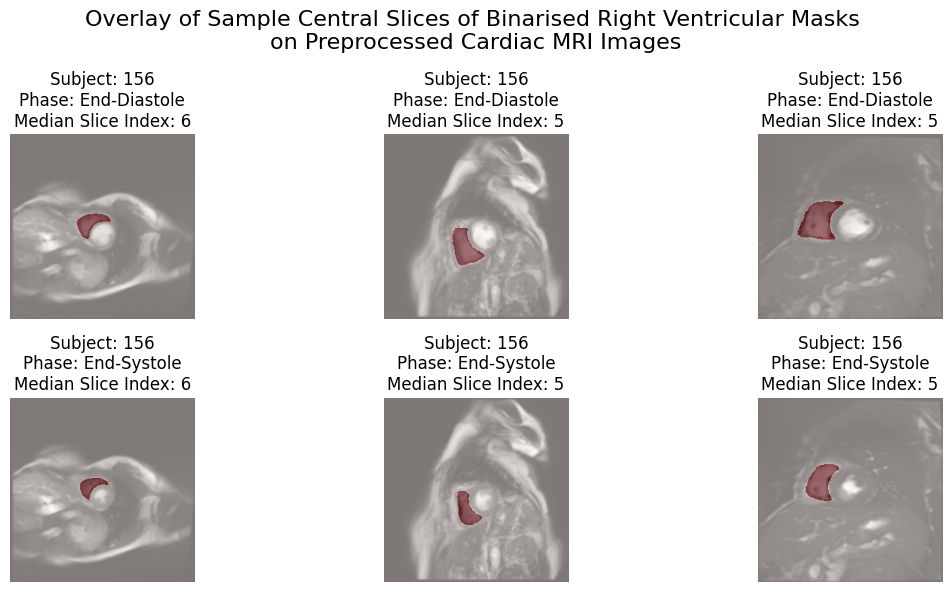

In [39]:
plt.figure(figsize=(12, 6))

for col, ((img_ed_path, img_es_path), (mask_ed_path, mask_es_path)) in enumerate(zip(example_img_pairs, example_mask_pairs)):
    for row, (img_path, mask_path, phase) in enumerate(zip([img_ed_path, img_es_path], [mask_ed_path, mask_es_path], ['End-Diastole', 'End-Systole'])):
        
        # Load image and mask
        img_nifti = nib.load(img_path)
        mask_nifti = nib.load(mask_path)

        img_data = img_nifti.get_fdata()
        mask_data = mask_nifti.get_fdata()

        # Find a central non-empty slice in the mask
        slice_idx = mask_data.shape[2] // 2
        while slice_idx < mask_data.shape[2] and np.sum(mask_data[:, :, slice_idx]) == 0:
            slice_idx += 1

        # Extract subject ID from filename
        filename = os.path.basename(path)  # eg. 001_SA_ED_gt.nii.gz
        subject_id = filename.split('_')[0]

        # Plot image with mask overlay
        plt.subplot(2, 3, row * 3 + col + 1)
        plt.imshow(img_data[:, :, slice_idx], cmap='gray')
        plt.imshow(mask_data[:, :, slice_idx], cmap='Reds', alpha=0.5)
        plt.title(f"Subject: {subject_id}\nPhase: {phase}\nMedian Slice Index: {slice_idx}", fontsize=12)
        plt.axis('off')

plt.suptitle("Overlay of Sample Central Slices of Binarised Right Ventricular Masks \non Preprocessed Cardiac MRI Images", fontsize=16)
plt.tight_layout()
plt.show()

## Extract 2D Slices from 3D MRI Images and Masks

In [40]:
extract_slices(path_data=path_out_3d, path_out=path_out_2dslices, df_csv=selected_df_csv)

Extracting slices: 100%|██████████| 1440/1440 [01:48<00:00, 13.28it/s] 

Extracting slices complete...
All extracted slices have been saved to: ./MnM2_preprocessed_2Dslices/


# Dataloader

In [41]:
# Training dataset with augmentation
train_dataset = CardiacMRIDataset(
    image_dir=path_train_images_2d,
    mask_dir=path_train_masks_2d,
    transform=get_train_transform()
)

# Validation dataset with minimal transforms
val_dataset = CardiacMRIDataset(
    image_dir=path_val_images_2d,
    mask_dir=path_val_masks_2d,
    transform=get_eval_transform()
)

test_dataset = CardiacMRIDataset(
    image_dir=path_test_images_2d,
    mask_dir=path_test_masks_2d,
    transform=get_eval_transform(),                     
    info_csv_path=r".\MnM2\dataset_information.csv",
    disease_filter=["NOR", "LV", "HCM"]                 # <- the key line
)

In [42]:
len(test_dataset), test_dataset.image_filenames[:3]

(1812,
 ['201_SA_ED_0000.nii.gz', '201_SA_ED_0001.nii.gz', '201_SA_ED_0002.nii.gz'])

In [43]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [44]:
len(train_loader)

275

In [45]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [46]:
def get_deeplabv3plus(in_channels=1, num_classes=2, encoder_name="resnet34"):
    return smp.DeepLabV3Plus(
        encoder_name=encoder_name,
        encoder_weights="imagenet",
        in_channels=in_channels,
        classes=num_classes
    )

In [47]:
def get_pspnet(in_channels=1, num_classes=1, encoder_name="resnet34"):
    return smp.PSPNet(
        encoder_name=encoder_name,       # Backbone (e.g., resnet34, resnet50)
        encoder_weights="imagenet",      # Use pretrained encoder weights
        in_channels=in_channels,         # Input channels (1 for grayscale MRI)
        classes=num_classes              # Output channels (1 for binary, >1 for multiclass)
    )

## Trainer Function

In [48]:
import os, copy, json
from typing import Dict, Any, Tuple, Optional
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import ReduceLROnPlateau

# =================== Metrics ===================
def dice_coef(preds: torch.Tensor, targets: torch.Tensor, smooth: float = 1e-6) -> torch.Tensor:
    """preds expected as probabilities in [0,1]; thresholded inside."""
    preds = (preds > 0.5).float()
    intersection = (preds * targets).sum()
    return (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

def iou_coef(preds: torch.Tensor, targets: torch.Tensor, smooth: float = 1e-6) -> torch.Tensor:
    preds = (preds > 0.5).float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return (intersection + smooth) / (union + smooth)

# =================== Loss wrapper ===================
class CombinedLoss(nn.Module):
    def __init__(self, dice_weight: float = 1.0, bce_weight: float = 1.0):
        super().__init__()
        self.dice = smp.losses.DiceLoss(mode="binary")
        self.bce  = nn.BCEWithLogitsLoss()
        self.dw = dice_weight
        self.bw = bce_weight
    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        return self.dw * self.dice(logits, targets) + self.bw * self.bce(logits, targets)

# =================== Trainer (AMP updated) ===================
def train_segmentation_model(
    model: nn.Module,
    train_loader,
    val_loader,
    model_name: str,
    epochs: int = 10,
    lr: float = 1e-4,
    weight_decay: float = 1e-5,
    dice_weight: float = 1.0,
    bce_weight: float = 1.0,
    grad_clip: float = 0.0,                  # set >0 to enable grad clipping
    checkpoints_dir: str = "checkpoints",
    device: Optional[str] = None,
    use_amp: bool = False,                    # turn on mixed precision on CUDA
    amp_dtype: Optional[torch.dtype] = None   # e.g., torch.float16 or torch.bfloat16
) -> Tuple[nn.Module, Dict[str, Any]]:

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    device = torch.device(device)
    model = model.to(device)

    os.makedirs(checkpoints_dir, exist_ok=True)

    criterion  = CombinedLoss(dice_weight=dice_weight, bce_weight=bce_weight)
    optimizer  = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler  = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    # AMP is only meaningful on CUDA
    amp_enabled = use_amp and device.type == "cuda"
    scaler = torch.amp.GradScaler('cuda', enabled=amp_enabled)

    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    history = {'train_loss': [], 'val_loss': [], 'val_dice': [], 'val_iou': []}

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}\n" + "-"*40)

        # ===== Train =====
        model.train()
        train_loss = 0.0
        for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
            imgs, masks = imgs.to(device), masks.to(device).float()
            if imgs.dim() == 3:  imgs = imgs.unsqueeze(1)
            if masks.dim() == 3: masks = masks.unsqueeze(1)

            optimizer.zero_grad(set_to_none=True)

            # Forward + loss (AMP)
            with torch.amp.autocast('cuda', enabled=amp_enabled, dtype=amp_dtype):
                logits = model(imgs)
                loss = criterion(logits, masks)

            # Backward + step (AMP-safe)
            scaler.scale(loss).backward()

            if grad_clip and grad_clip > 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)

            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()

        avg_train_loss = train_loss / max(1, len(train_loader))

        # ===== Validate =====
        model.eval()
        val_loss, val_dice_sum, val_iou_sum, total_samples = 0.0, 0.0, 0.0, 0
        with torch.inference_mode():
            for imgs, masks in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
                imgs, masks = imgs.to(device), masks.to(device).float()
                if imgs.dim() == 3:  imgs = imgs.unsqueeze(1)
                if masks.dim() == 3: masks = masks.unsqueeze(1)

                with torch.amp.autocast('cuda', enabled=amp_enabled, dtype=amp_dtype):
                    logits = model(imgs)
                    loss = criterion(logits, masks)
                    probs = torch.sigmoid(logits)

                val_loss += loss.item()
                bsz = imgs.size(0)
                val_dice_sum += dice_coef(probs.detach(), masks).item() * bsz
                val_iou_sum  += iou_coef(probs.detach(),  masks).item() * bsz
                total_samples += bsz

        avg_val_loss = val_loss / max(1, len(val_loader))
        avg_val_dice = val_dice_sum / max(1, total_samples)
        avg_val_iou  = val_iou_sum  / max(1, total_samples)

        print(
            f"Train Loss: {avg_train_loss:.4f} | "
            f"Val Loss: {avg_val_loss:.4f} | "
            f"Val Dice: {avg_val_dice:.4f} | "
            f"Val IoU: {avg_val_iou:.4f}"
        )

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_dice'].append(avg_val_dice)
        history['val_iou'].append(avg_val_iou)

        scheduler.step(avg_val_loss)

        # Save best
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            ckpt_path = os.path.join(checkpoints_dir, f"best_{model_name}.pth")
            torch.save(best_model_wts, ckpt_path)
            print(f"✅ Best model saved to {ckpt_path}")

    # Load best and return
    model.load_state_dict(best_model_wts)
    print(f"\nTraining complete. Best validation loss: {best_val_loss:.4f}")

    with open(os.path.join(checkpoints_dir, f"history_{model_name}.json"), "w") as f:
        json.dump(history, f)

    return model, history


## Tester Function

In [49]:
from tqdm import tqdm
import torch

def evaluate_model(model, test_loader, device):
    model.eval()
    sum_dice, sum_iou, n_samples = 0.0, 0.0, 0
    with torch.inference_mode():
        for batch in tqdm(test_loader, desc="Testing"):
            if isinstance(batch, (list, tuple)) and len(batch) == 3:
                imgs, masks, _ = batch
            else:
                imgs, masks = batch

            imgs, masks = imgs.to(device), masks.to(device).float()
            if imgs.dim() == 3:  imgs = imgs.unsqueeze(1)
            if masks.dim() == 3: masks = masks.unsqueeze(1)

            logits = model(imgs)
            probs  = torch.sigmoid(logits).detach()

            bsz = imgs.size(0)
            sum_dice += dice_coef(probs, masks).item() * bsz
            sum_iou  += iou_coef(probs, masks).item()  * bsz
            n_samples += bsz

    return (sum_dice / max(1, n_samples), sum_iou / max(1, n_samples))

## Train DeepLabV3+

In [50]:
# DeepLabV3+ with AMP
deeplab = get_deeplabv3plus(in_channels=1, num_classes=1)
deeplab, hist_dl = train_segmentation_model(
    deeplab, train_loader, val_loader,
    model_name="deeplabv3plus",
    epochs=25,
    use_amp=True,      # turn on mixed precision if CUDA
    grad_clip=1.0
)


Epoch 1/25
----------------------------------------


Epoch 1 [Val]: 100%|██████████| 41/41 [00:07<00:00,  5.51it/s]


Train Loss: 1.1392 | Val Loss: 0.8519 | Val Dice: 0.5232 | Val IoU: 0.3702
✅ Best model saved to checkpoints\best_deeplabv3plus.pth

Epoch 2/25
----------------------------------------


Epoch 2 [Val]: 100%|██████████| 41/41 [00:02<00:00, 16.21it/s]


Train Loss: 0.6354 | Val Loss: 0.5430 | Val Dice: 0.6053 | Val IoU: 0.4536
✅ Best model saved to checkpoints\best_deeplabv3plus.pth

Epoch 3/25
----------------------------------------


Epoch 3 [Val]: 100%|██████████| 41/41 [00:02<00:00, 15.81it/s]


Train Loss: 0.4314 | Val Loss: 0.4495 | Val Dice: 0.6220 | Val IoU: 0.4916
✅ Best model saved to checkpoints\best_deeplabv3plus.pth

Epoch 4/25
----------------------------------------


Epoch 4 [Val]: 100%|██████████| 41/41 [00:03<00:00, 13.37it/s]


Train Loss: 0.3274 | Val Loss: 0.3873 | Val Dice: 0.6503 | Val IoU: 0.5129
✅ Best model saved to checkpoints\best_deeplabv3plus.pth

Epoch 5/25
----------------------------------------


Epoch 5 [Val]: 100%|██████████| 41/41 [00:02<00:00, 15.38it/s]


Train Loss: 0.2880 | Val Loss: 0.3231 | Val Dice: 0.7156 | Val IoU: 0.5838
✅ Best model saved to checkpoints\best_deeplabv3plus.pth

Epoch 6/25
----------------------------------------


Epoch 6 [Val]: 100%|██████████| 41/41 [00:02<00:00, 16.54it/s]


Train Loss: 0.2530 | Val Loss: 0.3083 | Val Dice: 0.7217 | Val IoU: 0.5900
✅ Best model saved to checkpoints\best_deeplabv3plus.pth

Epoch 7/25
----------------------------------------


Epoch 7 [Val]: 100%|██████████| 41/41 [00:02<00:00, 16.72it/s]


Train Loss: 0.2345 | Val Loss: 0.3207 | Val Dice: 0.7094 | Val IoU: 0.5789

Epoch 8/25
----------------------------------------


Epoch 8 [Val]: 100%|██████████| 41/41 [00:02<00:00, 16.69it/s]


Train Loss: 0.2160 | Val Loss: 0.3116 | Val Dice: 0.7181 | Val IoU: 0.5894

Epoch 9/25
----------------------------------------


Epoch 9 [Val]: 100%|██████████| 41/41 [00:02<00:00, 16.83it/s]


Train Loss: 0.2115 | Val Loss: 0.3123 | Val Dice: 0.7137 | Val IoU: 0.5835

Epoch 10/25
----------------------------------------


Epoch 10 [Val]: 100%|██████████| 41/41 [00:02<00:00, 16.47it/s]


Train Loss: 0.1990 | Val Loss: 0.2930 | Val Dice: 0.7303 | Val IoU: 0.6051
✅ Best model saved to checkpoints\best_deeplabv3plus.pth

Epoch 11/25
----------------------------------------


Epoch 11 [Val]: 100%|██████████| 41/41 [00:02<00:00, 16.45it/s]


Train Loss: 0.1844 | Val Loss: 0.2796 | Val Dice: 0.7436 | Val IoU: 0.6164
✅ Best model saved to checkpoints\best_deeplabv3plus.pth

Epoch 12/25
----------------------------------------


Epoch 12 [Val]: 100%|██████████| 41/41 [00:02<00:00, 16.45it/s]


Train Loss: 0.1826 | Val Loss: 0.2888 | Val Dice: 0.7321 | Val IoU: 0.6115

Epoch 13/25
----------------------------------------


Epoch 13 [Val]: 100%|██████████| 41/41 [00:02<00:00, 16.22it/s]


Train Loss: 0.1726 | Val Loss: 0.2831 | Val Dice: 0.7406 | Val IoU: 0.6188

Epoch 14/25
----------------------------------------


Epoch 14 [Val]: 100%|██████████| 41/41 [00:02<00:00, 16.70it/s]


Train Loss: 0.1692 | Val Loss: 0.2997 | Val Dice: 0.7233 | Val IoU: 0.6023

Epoch 15/25
----------------------------------------


Epoch 15 [Val]: 100%|██████████| 41/41 [00:02<00:00, 16.25it/s]


Train Loss: 0.1642 | Val Loss: 0.2843 | Val Dice: 0.7380 | Val IoU: 0.6056

Epoch 16/25
----------------------------------------


Epoch 16 [Val]: 100%|██████████| 41/41 [00:02<00:00, 17.05it/s]


Train Loss: 0.1533 | Val Loss: 0.2805 | Val Dice: 0.7413 | Val IoU: 0.6160

Epoch 17/25
----------------------------------------


Epoch 17 [Val]: 100%|██████████| 41/41 [00:02<00:00, 15.95it/s]


Train Loss: 0.1442 | Val Loss: 0.2788 | Val Dice: 0.7438 | Val IoU: 0.6217
✅ Best model saved to checkpoints\best_deeplabv3plus.pth

Epoch 18/25
----------------------------------------


Epoch 18 [Val]: 100%|██████████| 41/41 [00:02<00:00, 16.73it/s]


Train Loss: 0.1373 | Val Loss: 0.2792 | Val Dice: 0.7426 | Val IoU: 0.6180

Epoch 19/25
----------------------------------------


Epoch 19 [Val]: 100%|██████████| 41/41 [00:02<00:00, 16.28it/s]


Train Loss: 0.1329 | Val Loss: 0.2728 | Val Dice: 0.7497 | Val IoU: 0.6267
✅ Best model saved to checkpoints\best_deeplabv3plus.pth

Epoch 20/25
----------------------------------------


Epoch 20 [Val]: 100%|██████████| 41/41 [00:02<00:00, 16.72it/s]


Train Loss: 0.1290 | Val Loss: 0.2769 | Val Dice: 0.7487 | Val IoU: 0.6306

Epoch 21/25
----------------------------------------


Epoch 21 [Val]: 100%|██████████| 41/41 [00:02<00:00, 16.56it/s]


Train Loss: 0.1253 | Val Loss: 0.2788 | Val Dice: 0.7449 | Val IoU: 0.6249

Epoch 22/25
----------------------------------------


Epoch 22 [Val]: 100%|██████████| 41/41 [00:02<00:00, 16.94it/s]


Train Loss: 0.1222 | Val Loss: 0.2826 | Val Dice: 0.7419 | Val IoU: 0.6186

Epoch 23/25
----------------------------------------


Epoch 23 [Val]: 100%|██████████| 41/41 [00:02<00:00, 16.06it/s]


Train Loss: 0.1225 | Val Loss: 0.2849 | Val Dice: 0.7395 | Val IoU: 0.6202

Epoch 24/25
----------------------------------------


Epoch 24 [Val]: 100%|██████████| 41/41 [00:02<00:00, 16.78it/s]


Train Loss: 0.1192 | Val Loss: 0.2747 | Val Dice: 0.7497 | Val IoU: 0.6303

Epoch 25/25
----------------------------------------


Epoch 25 [Val]: 100%|██████████| 41/41 [00:02<00:00, 16.73it/s]

Train Loss: 0.1118 | Val Loss: 0.2773 | Val Dice: 0.7466 | Val IoU: 0.6262

Training complete. Best validation loss: 0.2728


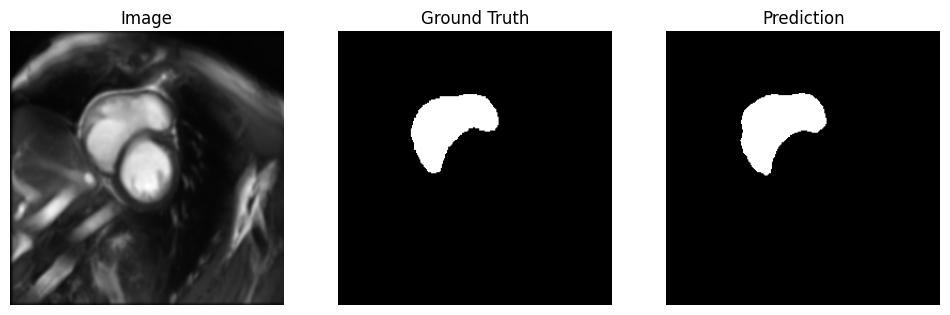

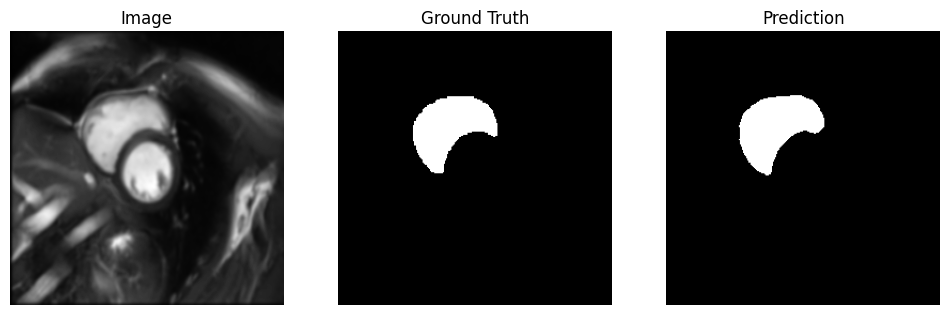

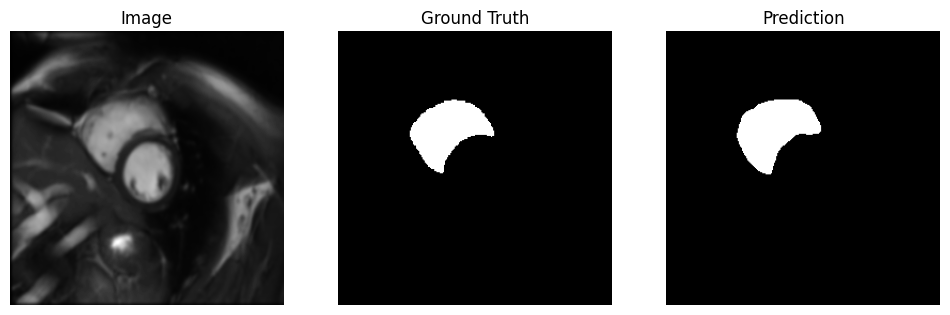

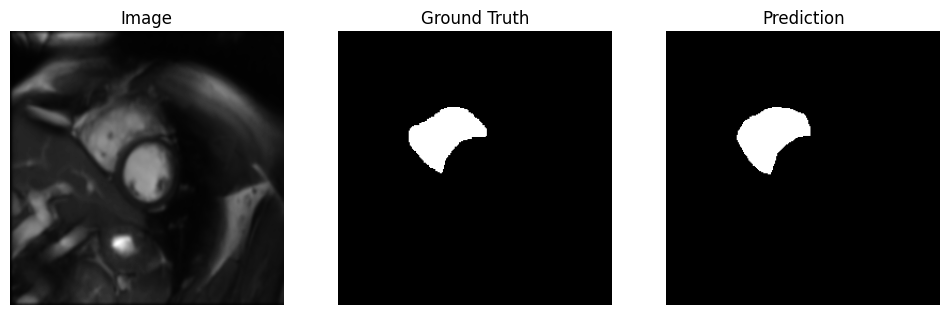

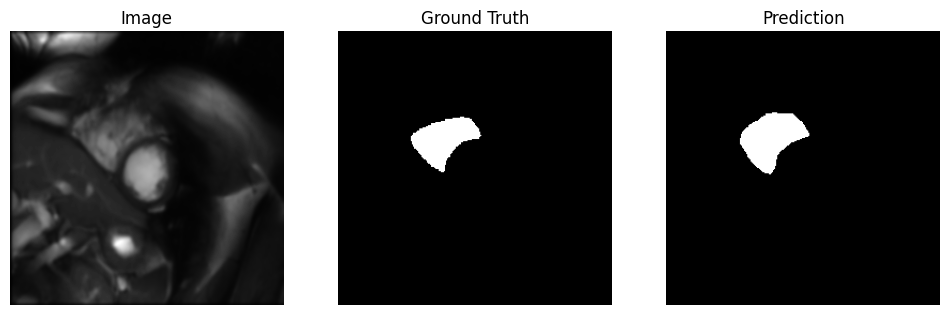

In [51]:
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# How many samples you want to display
num_samples_to_show = 5
shown = 0

# Pick which trained model to visualize
model_to_show = deeplab

model_to_show.eval()

with torch.no_grad():
    for imgs, masks in test_loader:
        imgs, masks = imgs.to(device), masks.to(device).float()

        non_zero_indices = [i for i in range(len(masks)) if torch.sum(masks[i]) > 0]
        if not non_zero_indices:
            continue

        preds = torch.sigmoid(model_to_show(imgs))
        preds_bin = (preds > 0.5).float()

        for i in non_zero_indices:
            if shown >= num_samples_to_show:
                break

            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(imgs[i, 0].cpu(), cmap='gray')
            plt.title("Image"); plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(masks[i, 0].cpu(), cmap='gray')
            plt.title("Ground Truth"); plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(preds_bin[i, 0].cpu(), cmap='gray')
            plt.title("Prediction"); plt.axis('off')

            plt.show()
            shown += 1

        if shown >= num_samples_to_show:
            break


In [52]:
non_zero_count = 0
total_count = 0

for _, masks in test_loader:
    for m in masks:
        if torch.sum(m) > 0:
            non_zero_count += 1
        total_count += 1

print(f"Non-zero masks: {non_zero_count}/{total_count} ({(non_zero_count/total_count)*100:.2f}%)")

Non-zero masks: 1052/1812 (58.06%)


## Testing DeepLabV3+ for Normal Cases

In [53]:
test_dataset = CardiacMRIDataset(
    image_dir=path_test_images_2d,
    mask_dir=path_test_masks_2d,
    transform=get_eval_transform(),                     
    info_csv_path=r".\MnM2\dataset_information.csv",
    disease_filter=["NOR"]                 # <- the key line
)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

len(test_loader)

# Usage after training:
test_dice, test_iou = evaluate_model(deeplab, test_loader, device)
print(f"\n✅ Test Dice: {test_dice:.4f} | Test IoU: {test_iou:.4f}")

Testing: 100%|██████████| 86/86 [00:06<00:00, 13.30it/s]


✅ Test Dice: 0.7928 | Test IoU: 0.6794


## Testing DeepLabV3+ for LV Cases

In [54]:
test_dataset = CardiacMRIDataset(
    image_dir=path_test_images_2d,
    mask_dir=path_test_masks_2d,
    transform=get_eval_transform(),                     
    info_csv_path=r".\MnM2\dataset_information.csv",
    disease_filter=["LV"]                 # <- the key line
)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

len(test_loader)

# Usage after training:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_dice, test_iou = evaluate_model(deeplab, test_loader, device)
print(f"\n✅ Test Dice: {test_dice:.4f} | Test IoU: {test_iou:.4f}")

Testing: 100%|██████████| 76/76 [00:05<00:00, 13.79it/s]


✅ Test Dice: 0.8242 | Test IoU: 0.7166


## Testing DeepLabV3+ for HCM Cases

In [55]:
test_dataset = CardiacMRIDataset(
    image_dir=path_test_images_2d,
    mask_dir=path_test_masks_2d,
    transform=get_eval_transform(),                     
    info_csv_path=r".\MnM2\dataset_information.csv",
    disease_filter=["HCM"]
)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

len(test_loader)

# Usage after training:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_dice, test_iou = evaluate_model(deeplab, test_loader, device)
print(f"\n✅ Test Dice: {test_dice:.4f} | Test IoU: {test_iou:.4f}")

Testing: 100%|██████████| 66/66 [00:04<00:00, 14.17it/s]


✅ Test Dice: 0.8113 | Test IoU: 0.6986


## Train PSPNet

In [56]:
# PSPNet
psp = get_pspnet(in_channels=1, num_classes=1)
psp, hist_psp = train_segmentation_model(
    psp, train_loader, val_loader,
    model_name="pspnet",
    epochs=25,
    use_amp=True
)


Epoch 1/25
----------------------------------------


Epoch 1 [Val]: 100%|██████████| 41/41 [00:02<00:00, 18.33it/s]


Train Loss: 0.7573 | Val Loss: 0.4346 | Val Dice: 0.6137 | Val IoU: 0.4685
✅ Best model saved to checkpoints\best_pspnet.pth

Epoch 2/25
----------------------------------------


Epoch 2 [Val]: 100%|██████████| 41/41 [00:02<00:00, 18.41it/s]


Train Loss: 0.4090 | Val Loss: 0.3827 | Val Dice: 0.6338 | Val IoU: 0.4980
✅ Best model saved to checkpoints\best_pspnet.pth

Epoch 3/25
----------------------------------------


Epoch 3 [Val]: 100%|██████████| 41/41 [00:02<00:00, 14.77it/s]


Train Loss: 0.3586 | Val Loss: 0.3607 | Val Dice: 0.6654 | Val IoU: 0.5335
✅ Best model saved to checkpoints\best_pspnet.pth

Epoch 4/25
----------------------------------------


Epoch 4 [Val]: 100%|██████████| 41/41 [00:02<00:00, 16.11it/s]


Train Loss: 0.3297 | Val Loss: 0.3178 | Val Dice: 0.7034 | Val IoU: 0.5732
✅ Best model saved to checkpoints\best_pspnet.pth

Epoch 5/25
----------------------------------------


Epoch 5 [Val]: 100%|██████████| 41/41 [00:02<00:00, 17.80it/s]


Train Loss: 0.2949 | Val Loss: 0.3502 | Val Dice: 0.6760 | Val IoU: 0.5457

Epoch 6/25
----------------------------------------


Epoch 6 [Val]: 100%|██████████| 41/41 [00:02<00:00, 18.38it/s]


Train Loss: 0.2831 | Val Loss: 0.3173 | Val Dice: 0.7025 | Val IoU: 0.5712
✅ Best model saved to checkpoints\best_pspnet.pth

Epoch 7/25
----------------------------------------


Epoch 7 [Val]: 100%|██████████| 41/41 [00:02<00:00, 18.98it/s]


Train Loss: 0.2776 | Val Loss: 0.3476 | Val Dice: 0.6779 | Val IoU: 0.5471

Epoch 8/25
----------------------------------------


Epoch 8 [Val]: 100%|██████████| 41/41 [00:02<00:00, 18.33it/s]


Train Loss: 0.2713 | Val Loss: 0.3477 | Val Dice: 0.6756 | Val IoU: 0.5440

Epoch 9/25
----------------------------------------


Epoch 9 [Val]: 100%|██████████| 41/41 [00:02<00:00, 18.75it/s]


Train Loss: 0.2613 | Val Loss: 0.3070 | Val Dice: 0.7236 | Val IoU: 0.5952
✅ Best model saved to checkpoints\best_pspnet.pth

Epoch 10/25
----------------------------------------


Epoch 10 [Val]: 100%|██████████| 41/41 [00:02<00:00, 18.93it/s]


Train Loss: 0.2568 | Val Loss: 0.3102 | Val Dice: 0.7190 | Val IoU: 0.5869

Epoch 11/25
----------------------------------------


Epoch 11 [Val]: 100%|██████████| 41/41 [00:02<00:00, 16.51it/s]


Train Loss: 0.2575 | Val Loss: 0.3170 | Val Dice: 0.7130 | Val IoU: 0.5810

Epoch 12/25
----------------------------------------


Epoch 12 [Val]: 100%|██████████| 41/41 [00:02<00:00, 18.01it/s]


Train Loss: 0.2420 | Val Loss: 0.3187 | Val Dice: 0.7100 | Val IoU: 0.5753

Epoch 13/25
----------------------------------------


Epoch 13 [Val]: 100%|██████████| 41/41 [00:02<00:00, 18.95it/s]


Train Loss: 0.2403 | Val Loss: 0.3070 | Val Dice: 0.7175 | Val IoU: 0.5865

Epoch 14/25
----------------------------------------


Epoch 14 [Val]: 100%|██████████| 41/41 [00:02<00:00, 18.32it/s]


Train Loss: 0.2179 | Val Loss: 0.2987 | Val Dice: 0.7275 | Val IoU: 0.5970
✅ Best model saved to checkpoints\best_pspnet.pth

Epoch 15/25
----------------------------------------


Epoch 15 [Val]: 100%|██████████| 41/41 [00:02<00:00, 17.38it/s]


Train Loss: 0.2137 | Val Loss: 0.2977 | Val Dice: 0.7274 | Val IoU: 0.5995
✅ Best model saved to checkpoints\best_pspnet.pth

Epoch 16/25
----------------------------------------


Epoch 16 [Val]: 100%|██████████| 41/41 [00:02<00:00, 17.68it/s]


Train Loss: 0.2152 | Val Loss: 0.3021 | Val Dice: 0.7240 | Val IoU: 0.5936

Epoch 17/25
----------------------------------------


Epoch 17 [Val]: 100%|██████████| 41/41 [00:02<00:00, 18.09it/s]


Train Loss: 0.2080 | Val Loss: 0.3093 | Val Dice: 0.7169 | Val IoU: 0.5873

Epoch 18/25
----------------------------------------


Epoch 18 [Val]: 100%|██████████| 41/41 [00:02<00:00, 18.37it/s]


Train Loss: 0.2090 | Val Loss: 0.3076 | Val Dice: 0.7178 | Val IoU: 0.5882

Epoch 19/25
----------------------------------------


Epoch 19 [Val]: 100%|██████████| 41/41 [00:02<00:00, 16.01it/s]


Train Loss: 0.1976 | Val Loss: 0.3033 | Val Dice: 0.7242 | Val IoU: 0.5941

Epoch 20/25
----------------------------------------


Epoch 20 [Val]: 100%|██████████| 41/41 [00:02<00:00, 18.18it/s]


Train Loss: 0.1958 | Val Loss: 0.3039 | Val Dice: 0.7237 | Val IoU: 0.5916

Epoch 21/25
----------------------------------------


Epoch 21 [Val]: 100%|██████████| 41/41 [00:02<00:00, 18.85it/s]


Train Loss: 0.1851 | Val Loss: 0.2995 | Val Dice: 0.7261 | Val IoU: 0.5965

Epoch 22/25
----------------------------------------


Epoch 22 [Val]: 100%|██████████| 41/41 [00:02<00:00, 17.37it/s]


Train Loss: 0.1908 | Val Loss: 0.3022 | Val Dice: 0.7235 | Val IoU: 0.5931

Epoch 23/25
----------------------------------------


Epoch 23 [Val]: 100%|██████████| 41/41 [00:02<00:00, 18.38it/s]


Train Loss: 0.1904 | Val Loss: 0.2926 | Val Dice: 0.7325 | Val IoU: 0.6050
✅ Best model saved to checkpoints\best_pspnet.pth

Epoch 24/25
----------------------------------------


Epoch 24 [Val]: 100%|██████████| 41/41 [00:02<00:00, 17.85it/s]


Train Loss: 0.1815 | Val Loss: 0.2954 | Val Dice: 0.7296 | Val IoU: 0.5997

Epoch 25/25
----------------------------------------


Epoch 25 [Val]: 100%|██████████| 41/41 [00:02<00:00, 17.13it/s]

Train Loss: 0.1791 | Val Loss: 0.3124 | Val Dice: 0.7134 | Val IoU: 0.5820

Training complete. Best validation loss: 0.2926


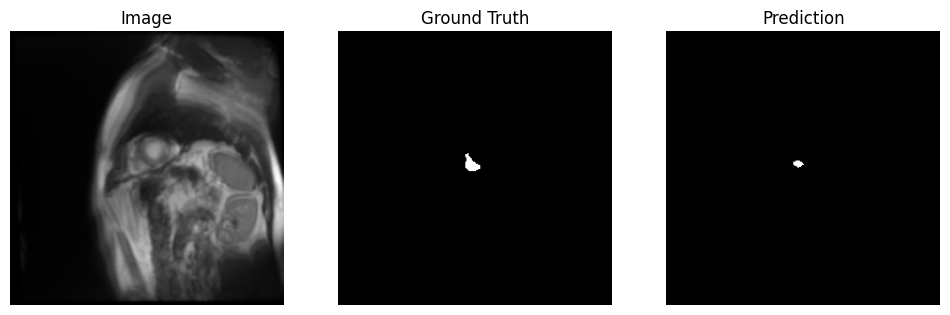

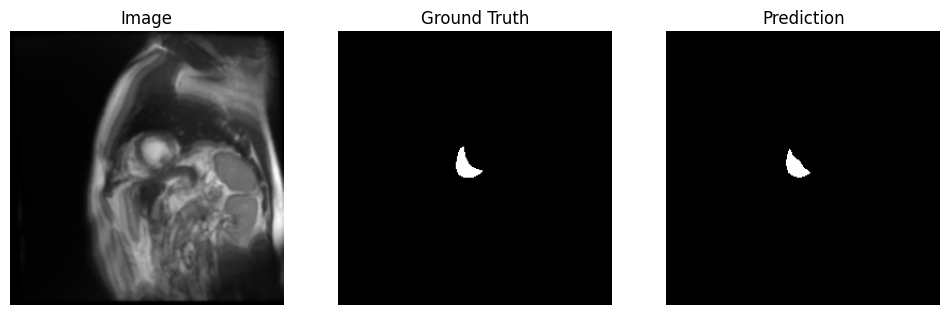

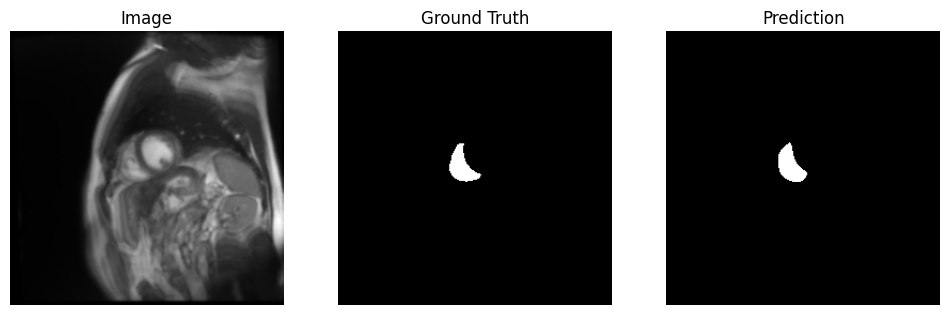

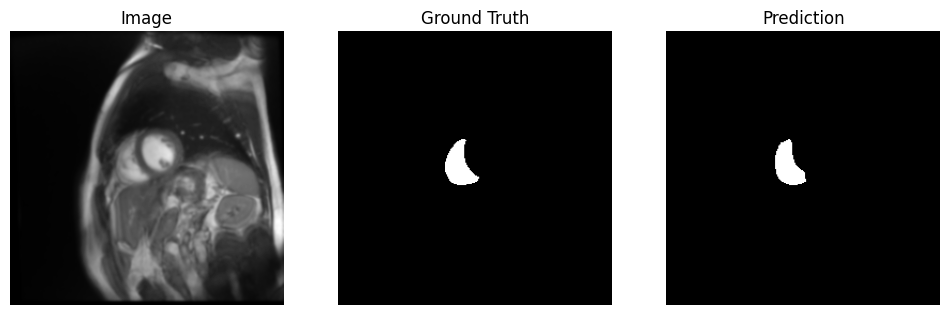

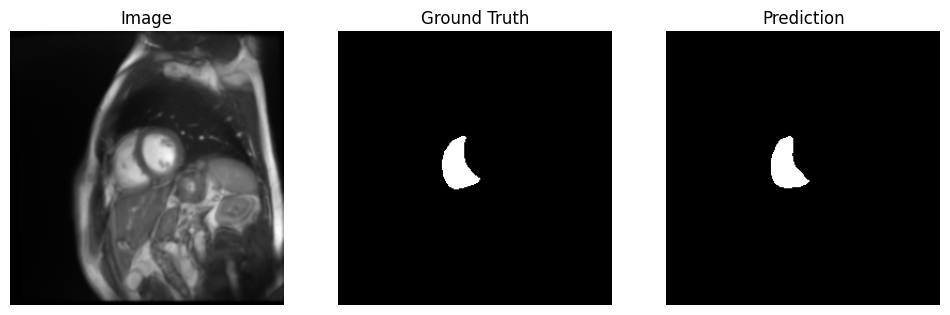

In [57]:
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# How many samples you want to display
num_samples_to_show = 5
shown = 0

# Pick which trained model to visualize
model_to_show = psp

model_to_show.eval()

with torch.no_grad():
    for imgs, masks in test_loader:
        imgs, masks = imgs.to(device), masks.to(device).float()

        non_zero_indices = [i for i in range(len(masks)) if torch.sum(masks[i]) > 0]
        if not non_zero_indices:
            continue

        preds = torch.sigmoid(model_to_show(imgs))
        preds_bin = (preds > 0.5).float()

        for i in non_zero_indices:
            if shown >= num_samples_to_show:
                break

            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(imgs[i, 0].cpu(), cmap='gray')
            plt.title("Image"); plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(masks[i, 0].cpu(), cmap='gray')
            plt.title("Ground Truth"); plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(preds_bin[i, 0].cpu(), cmap='gray')
            plt.title("Prediction"); plt.axis('off')

            plt.show()
            shown += 1

        if shown >= num_samples_to_show:
            break

## Testing PSPNet for Normal Cases

In [58]:
test_dataset = CardiacMRIDataset(
    image_dir=path_test_images_2d,
    mask_dir=path_test_masks_2d,
    transform=get_eval_transform(),                     
    info_csv_path=r".\MnM2\dataset_information.csv",
    disease_filter=["NOR"]                 # <- the key line
)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

len(test_loader)

# Usage after training:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_dice, test_iou = evaluate_model(psp, test_loader, device)
print(f"\n✅ Test Dice: {test_dice:.4f} | Test IoU: {test_iou:.4f}")

Testing: 100%|██████████| 86/86 [00:05<00:00, 15.62it/s]


✅ Test Dice: 0.7564 | Test IoU: 0.6296


## Testing PSPNet for LV Cases

In [59]:
test_dataset = CardiacMRIDataset(
    image_dir=path_test_images_2d,
    mask_dir=path_test_masks_2d,
    transform=get_eval_transform(),                     
    info_csv_path=r".\MnM2\dataset_information.csv",
    disease_filter=["LV"]                 # <- the key line
)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

len(test_loader)

# Usage after training:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_dice, test_iou = evaluate_model(psp, test_loader, device)
print(f"\n✅ Test Dice: {test_dice:.4f} | Test IoU: {test_iou:.4f}")

Testing: 100%|██████████| 76/76 [00:05<00:00, 14.20it/s]


✅ Test Dice: 0.8100 | Test IoU: 0.6942


## Testing PSPNet for HCM Cases

In [60]:
test_dataset = CardiacMRIDataset(
    image_dir=path_test_images_2d,
    mask_dir=path_test_masks_2d,
    transform=get_eval_transform(),                     
    info_csv_path=r".\MnM2\dataset_information.csv",
    disease_filter=["HCM"]                 # <- the key line
)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

len(test_loader)

# Usage after training:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_dice, test_iou = evaluate_model(psp, test_loader, device)
print(f"\n✅ Test Dice: {test_dice:.4f} | Test IoU: {test_iou:.4f}")

Testing: 100%|██████████| 66/66 [00:04<00:00, 16.37it/s]


✅ Test Dice: 0.7935 | Test IoU: 0.6741
